In [185]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [186]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras import layers
import joblib

np.random.seed(13)

In [187]:
np.random.seed(13)
set_seed(1)
logins_per_user = 150
time_steps = 10

In [188]:
df = pd.read_csv('../../preprocessing/final_processed_user_data_un.csv')
test_df = pd.read_csv('../../preprocessing/final_processed_user_data_un_test.csv')

In [189]:
print("class counts:\n", df["is_malicious"].value_counts())
print("\n%% of positive values in data: %.2f%%" % 
       ((df[df["is_malicious"] == 1].shape[0] / df.shape[0]) * 100))

class counts:
 0    46650
Name: is_malicious, dtype: int64

% of positive values in data: 0.00%


In [190]:
#append the test data to the training data
df_for_encoding = df.append(test_df)

/var/folders/9r/mynryq4x5234hzzqwgfzcd5h0000gn/T/ipykernel_85121/3294716345.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_for_encoding = df.append(test_df)


In [191]:
id_encoder = LabelEncoder()
id_encoder.fit(df_for_encoding['user_id'].unique())

LabelEncoder()

In [192]:
country_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
country_encoder.fit(df_for_encoding['country'].unique().reshape(-1, 1))

browser_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
browser_encoder.fit(df_for_encoding['browser'].unique().reshape(-1, 1))

OS_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OS_encoder.fit(df_for_encoding['os_version'].unique().reshape(-1, 1))

device_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
device_encoder.fit(df_for_encoding['device'].unique().reshape(-1, 1))

time_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
time_encoder.fit(df_for_encoding['login_time'].unique().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [193]:
transformed_uid = id_encoder.transform(test_df['user_id'].to_numpy().reshape(-1, 1))
encoded_uid= pd.DataFrame(transformed_uid, columns=['uid_code'])
test_df = pd.concat([test_df, encoded_uid], axis=1).drop(['user_id'], axis=1)

/Users/dinika/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [194]:
transformed_uid = id_encoder.transform(df['user_id'].to_numpy().reshape(-1, 1))
encoded_uid= pd.DataFrame(transformed_uid, columns=['uid_code'])
df = pd.concat([df, encoded_uid], axis=1).drop(['user_id'], axis=1)

/Users/dinika/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [195]:
df.head()

,timestamp,login_time,country,browser,os_version,device,login_status,is_malicious,uid_code
0,1593632685344000000,late_evening,NO,Chrome,Chrome OS,desktop,1,0,148
1,1593719670520000000,late_evening,NO,Chrome,Chrome OS,desktop,1,0,148
2,1593777806076000000,noon,NO,Chrome,Chrome OS,desktop,1,0,148
3,1593807804925000000,late_evening,NO,Chrome,Chrome OS,desktop,1,0,148
4,1593887704289000000,evening,NO,Chrome,Chrome OS,desktop,1,0,148


In [196]:
min_max_scaler = MinMaxScaler()
uid_scaled = min_max_scaler.fit_transform(df['uid_code'].to_numpy().reshape(-1, 1))
uid_scaled = pd.DataFrame(uid_scaled, columns=['uid_scaled'])
df = pd.concat([df, uid_scaled], axis=1).drop(['uid_code'], axis=1)

In [197]:
uid_scaled = min_max_scaler.fit_transform(test_df['uid_code'].to_numpy().reshape(-1, 1))
uid_scaled = pd.DataFrame(uid_scaled, columns=['uid_scaled'])
test_df = pd.concat([test_df, uid_scaled], axis=1).drop(['uid_code'], axis=1)

In [198]:
df.head()

,timestamp,login_time,country,browser,os_version,device,login_status,is_malicious,uid_scaled
0,1593632685344000000,late_evening,NO,Chrome,Chrome OS,desktop,1,0,0.449848
1,1593719670520000000,late_evening,NO,Chrome,Chrome OS,desktop,1,0,0.449848
2,1593777806076000000,noon,NO,Chrome,Chrome OS,desktop,1,0,0.449848
3,1593807804925000000,late_evening,NO,Chrome,Chrome OS,desktop,1,0,0.449848
4,1593887704289000000,evening,NO,Chrome,Chrome OS,desktop,1,0,0.449848


In [199]:
transformed_country = country_encoder.transform(df['country'].to_numpy().reshape(-1, 1))
ohe_df_contry = pd.DataFrame(transformed_country, columns=country_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_contry], axis=1).drop(['country'], axis=1)

In [200]:
transformed_country = country_encoder.transform(test_df['country'].to_numpy().reshape(-1, 1))
ohe_df_contry = pd.DataFrame(transformed_country, columns=country_encoder.get_feature_names_out())
test_df = pd.concat([test_df, ohe_df_contry], axis=1).drop(['country'], axis=1)

In [201]:
transformed_browser = browser_encoder.transform(df['browser'].to_numpy().reshape(-1, 1))
ohe_df_browser = pd.DataFrame(transformed_browser, columns=browser_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_browser], axis=1).drop(['browser'], axis=1)

In [202]:
transformed_browser = browser_encoder.transform(test_df['browser'].to_numpy().reshape(-1, 1))
ohe_df_browser = pd.DataFrame(transformed_browser, columns=browser_encoder.get_feature_names_out())
test_df = pd.concat([test_df, ohe_df_browser], axis=1).drop(['browser'], axis=1)

In [203]:
transformed_os = OS_encoder.transform(df['os_version'].to_numpy().reshape(-1, 1))
ohe_df_os_version = pd.DataFrame(transformed_os, columns=OS_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_os_version], axis=1).drop(['os_version'], axis=1)

In [204]:
transformed_os = OS_encoder.transform(test_df['os_version'].to_numpy().reshape(-1, 1))
ohe_df_os_version = pd.DataFrame(transformed_os, columns=OS_encoder.get_feature_names_out())
test_df = pd.concat([test_df, ohe_df_os_version], axis=1).drop(['os_version'], axis=1)

In [205]:
transformed_device = device_encoder.transform(df['device'].to_numpy().reshape(-1, 1))
ohe_df_device = pd.DataFrame(transformed_device, columns=device_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_device], axis=1).drop(['device'], axis=1)

In [206]:
transformed_device = device_encoder.transform(test_df['device'].to_numpy().reshape(-1, 1))
ohe_df_device = pd.DataFrame(transformed_device, columns=device_encoder.get_feature_names_out())
test_df = pd.concat([test_df, ohe_df_device], axis=1).drop(['device'], axis=1)

In [207]:
transformed_time = time_encoder.transform(df['login_time'].to_numpy().reshape(-1, 1))
ohe_df_time = pd.DataFrame(transformed_time, columns=time_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_time], axis=1).drop(['login_time'], axis=1)

In [208]:
transformed_time = time_encoder.transform(test_df['login_time'].to_numpy().reshape(-1, 1))
ohe_df_time = pd.DataFrame(transformed_time, columns=time_encoder.get_feature_names_out())
test_df = pd.concat([test_df, ohe_df_time], axis=1).drop(['login_time'], axis=1)

In [209]:
joblib.dump(id_encoder,"encoders/id_encoder.joblib")
joblib.dump(country_encoder,"encoders/country_encoder.joblib")
joblib.dump(browser_encoder,"encoders/browser_encoder.joblib")
joblib.dump(OS_encoder,"encoders/OS_encoder.joblib")
joblib.dump(device_encoder,"encoders/device_encoder.joblib")
joblib.dump(time_encoder,"encoders/time_encoder.joblib")
joblib.dump(min_max_scaler,"encoders/uid_min_max_scaler.joblib")

['encoders/uid_min_max_scaler.joblib']

In [210]:
df.head()

,timestamp,login_status,is_malicious,uid_scaled,x0_AU,x0_BE,x0_BR,x0_CA,x0_CH,x0_CZ,...,x0_unknown,x0_afternoon,x0_early_morning,x0_evening,x0_late_evening,x0_late_morning,x0_late_night,x0_morning,x0_night,x0_noon
0,1593632685344000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1593719670520000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1593777806076000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1593807804925000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1593887704289000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
predictors = df.drop(["is_malicious"], axis = 1)
predictors = df.drop(["timestamp"], axis = 1)
target = df["is_malicious"]

In [212]:
predictors_test = test_df.drop(["is_malicious"], axis = 1)
predictors_test = test_df.drop(["timestamp"], axis = 1)
target_test = test_df["is_malicious"]

In [213]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: is_malicious, dtype: int64

In [214]:
predictors.head()

,login_status,is_malicious,uid_scaled,x0_AU,x0_BE,x0_BR,x0_CA,x0_CH,x0_CZ,x0_DE,...,x0_unknown,x0_afternoon,x0_early_morning,x0_evening,x0_late_evening,x0_late_morning,x0_late_night,x0_morning,x0_night,x0_noon
0,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
target.value_counts()

0    46650
Name: is_malicious, dtype: int64

In [216]:
len(predictors)

46650

In [217]:
len(target)

46650

In [218]:
def split_data(sequences, train_fraction, validation_fraction, test_fraaction):
    train_size = int(len(sequences) * train_fraction)
    validation_size = int(len(sequences) * validation_fraction)
    test_size = int(len(sequences) * test_fraaction)
    train, validation, test = sequences[:train_size], sequences[train_size:train_size+validation_size], sequences[train_size+validation_size:]
    return train, validation, test

In [219]:
columns = df.columns
write_colunms = True
user_data_file = "../../data/Autoencoder_user_data/user_past_data.csv"

train_x = []
train_y = []
test_x = []
test_y = []
val_x = []
val_y = []

unique_users = df['uid_scaled'].unique().tolist()
unique_users_test = test_df['uid_scaled'].unique().tolist()
#unique_users = df_sample['a'].unique().tolist()

for user in unique_users:
    user_df = df[df['uid_scaled'] == user]
    to_csv = user_df.tail(time_steps)
    to_csv.to_csv(user_data_file, mode='a', header=write_colunms, columns=columns)
    write_colunms = False
    predictors_local = user_df.drop(["is_malicious"], axis = 1)
    predictors_local = user_df.drop(["timestamp"], axis = 1)
    target_local = user_df["is_malicious"]
    user_sequences = []
    user_y_values = []
    for i in range(time_steps, len(user_df)+1):
        seq = predictors_local.iloc[i - time_steps:i].values
        user_sequences.append(seq)
        out_seq = target_local.iloc[i-1]
        user_y_values.append(out_seq)
    user_train_X, user_val_X, user_test_X = split_data(user_sequences,0.6,0.4,0.2) 
    user_train_y, user_val_y, user_test_y = split_data(user_y_values,0.6,0.4,0.2)
    train_x.extend(user_train_X)
    train_y.extend(user_train_y)
    val_x.extend(user_val_X)
    val_y.extend(user_val_y)
    test_x.extend(user_test_X)
    test_y.extend(user_test_y)

test_x = []
test_y = []

for user in unique_users_test:
    user_df = test_df[test_df['uid_scaled'] == user]
    predictors_local = user_df.drop(["is_malicious"], axis = 1)
    predictors_local = user_df.drop(["timestamp"], axis = 1)
    target_local = user_df["is_malicious"]
    user_sequences = []
    user_y_values = []
    for i in range(time_steps, len(user_df)+1):
        seq = predictors_local.iloc[i - time_steps:i].values
        user_sequences.append(seq)
        out_seq = target_local.iloc[i-1]
        user_y_values.append(out_seq)
    user_train_X, user_val_X, user_test_X = split_data(user_sequences,0.6,0.2,0.2) 
    user_train_y, user_val_y, user_test_y = split_data(user_y_values,0.6,0.2,0.2)
    test_x.extend(user_train_X)
    test_x.extend(user_val_X)
    test_x.extend(user_test_X)
    test_y.extend(user_train_y)
    test_y.extend(user_val_y)
    test_y.extend(user_test_y)

In [156]:
len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y)

(27990, 27990, 18660, 18660, 16500, 16500)

In [157]:
unique, counts = np.unique(train_y, return_counts=True)
print(unique, counts )


[0] [27990]


In [158]:
# print unique value counts in test_y
unique, counts = np.unique(test_y, return_counts=True)
print(unique, counts )

[0 1] [15848   652]


In [159]:
unique, counts = np.unique(val_y, return_counts=True)
print(unique, counts )

[0] [18660]


In [160]:
X_train = np.array(train_x)
y_train = np.array(train_y)
y_train = y_train.reshape(y_train.shape[0], 1)
X_val = np.array(val_x)
y_val = np.array(val_y)
y_val = y_val.reshape(y_val.shape[0], 1)
X_test = np.array(test_x)
y_test = np.array(test_y)
y_test = y_test.reshape(y_test.shape[0], 1)

In [161]:
print("X_train shape:\n", X_train.shape)
print("y_train shape:\n", y_train.shape)
print("X_val shape:\n", X_val.shape)
print("y_val shape:\n", y_val.shape)
print("X_test shape:\n", X_test.shape)
print("y_test shape:\n", y_test.shape)

X_train shape:
 (27990, 1, 76)
y_train shape:
 (27990, 1)
X_val shape:
 (18660, 1, 76)
y_val shape:
 (18660, 1)
X_test shape:
 (16500, 1, 76)
y_test shape:
 (16500, 1)


In [162]:
n_features = X_train.shape[2]

In [163]:
# model1 = keras.Sequential([
#     layers.LSTM(64, activation='relu', input_shape=(time_steps, n_features), return_sequences=True),
#     layers.LSTM(32, activation='relu', return_sequences=True),
#     layers.LSTM(32, activation='relu', return_sequences=True),
#     layers.LSTM(64, activation='relu', return_sequences=True),
#     layers.TimeDistributed(Dense(n_features))
# ])

# model1.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [178]:
# define model
model = keras.Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps,n_features), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 64)             36096     
                                                                 
 lstm_9 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_10 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_11 (LSTM)              (None, 1, 64)             24832     
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 76)            4940      
 tributed)                                                       
                                                                 
Total params: 86,604
Trainable params: 86,604
Non-trainable params: 0
__________________________________________________

In [179]:
batch_size = logins_per_user - time_steps + 1
batch_size

150

In [180]:
history = model.fit(X_train, X_train, epochs=10, batch_size=512, validation_data=(X_val, X_val), verbose=2, shuffle=False)

Epoch 1/10
55/55 - 3s - loss: 0.0759 - accuracy: 0.9161 - val_loss: 0.0659 - val_accuracy: 0.9333 - 3s/epoch - 60ms/step
Epoch 2/10
55/55 - 0s - loss: 0.0440 - accuracy: 0.6711 - val_loss: 0.0355 - val_accuracy: 0.9333 - 336ms/epoch - 6ms/step
Epoch 3/10
55/55 - 0s - loss: 0.0355 - accuracy: 0.7859 - val_loss: 0.0343 - val_accuracy: 0.9333 - 417ms/epoch - 8ms/step
Epoch 4/10
55/55 - 0s - loss: 0.0340 - accuracy: 0.7719 - val_loss: 0.0321 - val_accuracy: 0.9113 - 418ms/epoch - 8ms/step
Epoch 5/10
55/55 - 0s - loss: 0.0298 - accuracy: 0.7239 - val_loss: 0.0261 - val_accuracy: 0.5369 - 417ms/epoch - 8ms/step
Epoch 6/10
55/55 - 0s - loss: 0.0259 - accuracy: 0.3809 - val_loss: 0.0246 - val_accuracy: 0.2013 - 419ms/epoch - 8ms/step
Epoch 7/10
55/55 - 0s - loss: 0.0250 - accuracy: 0.2418 - val_loss: 0.0239 - val_accuracy: 0.1669 - 416ms/epoch - 8ms/step
Epoch 8/10
55/55 - 0s - loss: 0.0240 - accuracy: 0.2040 - val_loss: 0.0229 - val_accuracy: 0.0588 - 418ms/epoch - 8ms/step
Epoch 9/10
55/55 -

In [167]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

516/516 [==============================] - 0s 620us/step


In [168]:
print("train_pred shape:\n", train_pred.shape)
print("val_pred shape:\n", val_pred.shape)
print("test_pred shape:\n", test_pred.shape)

train_pred shape:
 (27990, 1, 76)
val_pred shape:
 (18660, 1, 76)
test_pred shape:
 (16500, 1, 76)


In [169]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [170]:
mse = np.mean(np.power(flatten(X_test) - flatten(test_pred), 2), axis=1)


In [171]:
mse.shape

(16500,)

In [172]:
# reshape y_test to 1D array
y_test_1 = y_test.reshape(y_test.shape[0],)

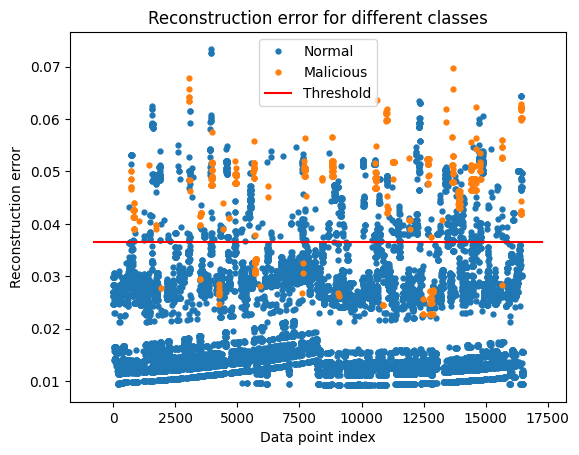

In [183]:
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test_1.tolist()})

threshold_fixed = 0.0365
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Malicious" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

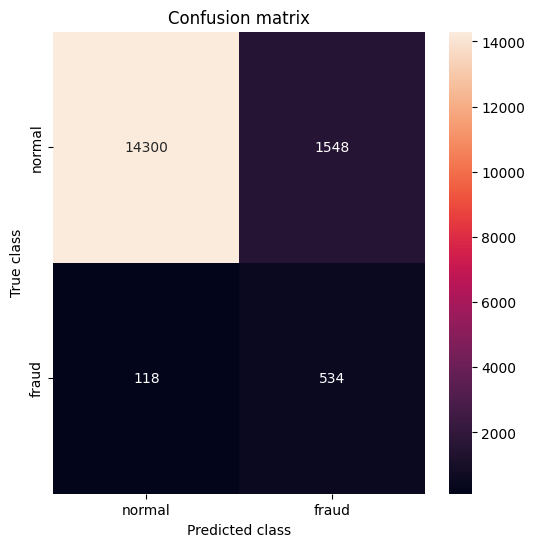

In [182]:
pred_y_out = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y_out)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels = ["normal", "fraud"], 
            yticklabels=["normal", "fraud"],  annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [175]:
#Store model
model.save('model/unsupervised_lstm.h5')